In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from fuzzywuzzy import fuzz, process
from sklearn.impute import KNNImputer
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler


/home/renzo/Documentos/boardgames-analysis/.venv/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Exercicio 1 

Valores ausentes por coluna:
price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

Porcentagem de valores ausentes:
price               0.0
area                0.0
bedrooms            0.0
bathrooms           0.0
stories             0.0
mainroad            0.0
guestroom           0.0
basement            0.0
hotwaterheating     0.0
airconditioning     0.0
parking             0.0
prefarea            0.0
furnishingstatus    0.0
dtype: float64


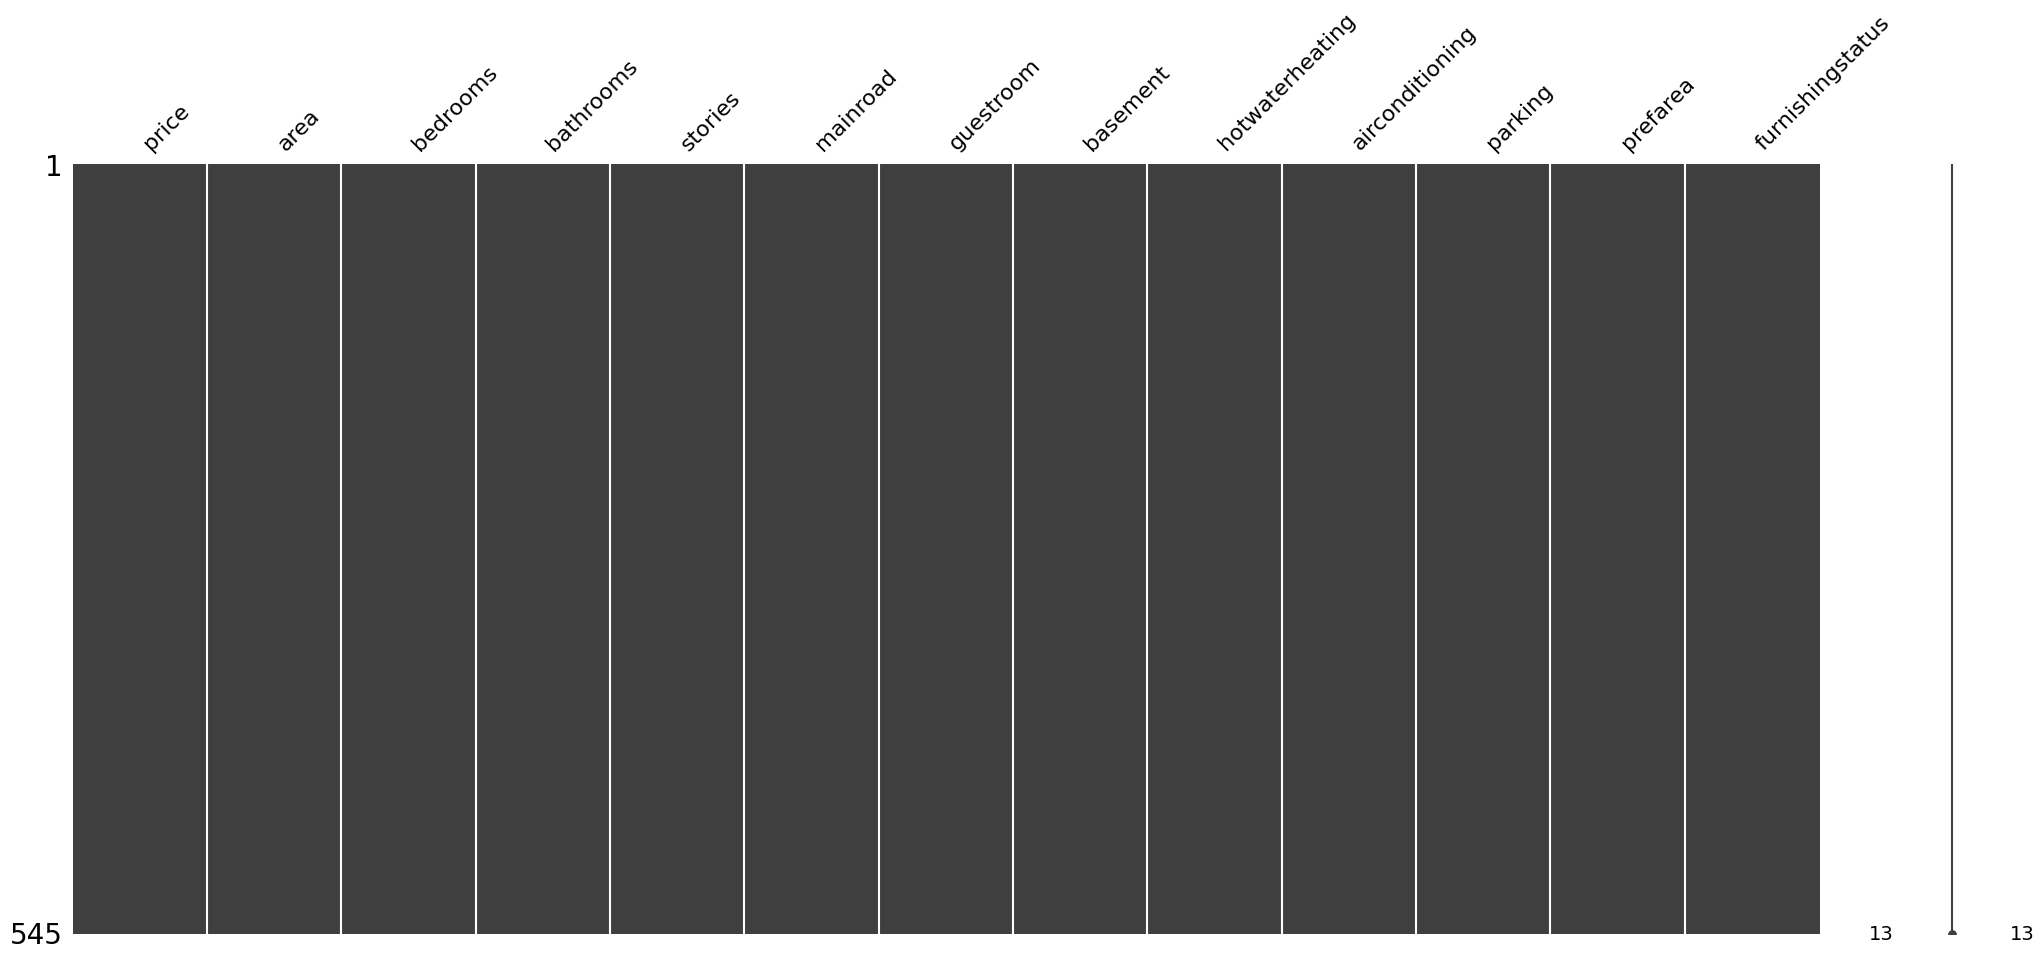


Original:
              price          area    bedrooms   bathrooms     stories  \
count  5.450000e+02    545.000000  545.000000  545.000000  545.000000   
mean   4.766729e+06   5150.541284    2.965138    1.286239    1.805505   
std    1.870440e+06   2170.141023    0.738064    0.502470    0.867492   
min    1.750000e+06   1650.000000    1.000000    1.000000    1.000000   
25%    3.430000e+06   3600.000000    2.000000    1.000000    1.000000   
50%    4.340000e+06   4600.000000    3.000000    1.000000    2.000000   
75%    5.740000e+06   6360.000000    3.000000    2.000000    2.000000   
max    1.330000e+07  16200.000000    6.000000    4.000000    4.000000   

          parking  
count  545.000000  
mean     0.693578  
std      0.861586  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      1.000000  
max      3.000000  

Remoção (drop):
              price          area    bedrooms   bathrooms     stories  \
count  5.450000e+02    545.000000  545.000000  545.000000  54

In [7]:
df = pd.read_csv('Housing.csv')

missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

print("Valores ausentes por coluna:")
print(missing_values)
print("\nPorcentagem de valores ausentes:")
print(missing_percentage)

msno.matrix(df)
plt.show()

cols_importantes = df.columns

df_drop = df.dropna(subset=cols_importantes)

df_media = df.copy()
numeric_cols = df_media.select_dtypes(include='number').columns
df_media[numeric_cols] = df_media[numeric_cols].fillna(df_media[numeric_cols].mean())

df_mediana = df.copy()
df_mediana[numeric_cols] = df_mediana[numeric_cols].fillna(df_mediana[numeric_cols].median())

df_knn = df.copy()
numeric_cols = df_knn.select_dtypes(include='number').columns
imputer = KNNImputer(n_neighbors=5)
df_knn[numeric_cols] = imputer.fit_transform(df_knn[numeric_cols])

print("\nOriginal:")
print(df[numeric_cols].describe())

print("\nRemoção (drop):")
print(df_drop[numeric_cols].describe())

print("\nImputação média:")
print(df_media[numeric_cols].describe())

print("\nImputação KNN:")
print(df_knn[numeric_cols].describe())

### Exercicio 2 

In [9]:
df = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', sheet_name='Transactions')

exact_duplicates = df.duplicated().sum()
print(f"Número de duplicatas exatas: {exact_duplicates}")

df_no_exact = df.drop_duplicates()
df_approx = df_no_exact.copy()

cols_texto = ['customer_id', 'customer_name', 'address']

for col in cols_texto:
    if col in df_approx.columns:
        df_approx[col + '_norm'] = (
            df_approx[col]
            .astype(str)
            .str.lower()
            .str.strip()
            .str.replace(r'\s+', ' ', regex=True)
        )

subset_cols = [c for c in df_approx.columns if c.endswith('_norm')]
approx_subset_dups = df_approx.duplicated(subset=subset_cols, keep=False) if subset_cols else pd.Series(False, index=df_approx.index)

print("\nPossíveis duplicatas aproximadas (por normalização simples):")
print(df_approx[approx_subset_dups].head())


def fuzzy_match_df(df, col, threshold=90):
    if col not in df.columns:
        return []
    valores = df[col].dropna().unique()
    grupos = []
    usados = set()
    for v in valores:
        if v in usados:
            continue
        similares = process.extract(v, valores, scorer=fuzz.token_set_ratio)
        grupo = [nome for nome, score in similares if score >= threshold]
        usados.update(grupo)
        if len(grupo) > 1:
            grupos.append(grupo)
    return grupos


if 'customer_name' in df_no_exact.columns:
    grupos_nomes = fuzzy_match_df(df_no_exact, 'customer_name', threshold=90)
    print("\nGrupos de nomes parecidos (fuzzy):")
    for g in grupos_nomes[:5]:
        print(g)
else:
    print("\nColuna 'customer_name' não encontrada — pulando fuzzy matching.")

keep_cols = ['customer_id', 'amount']
present_keep_cols = [c for c in keep_cols if c in df_no_exact.columns]

if 'transaction_date' in df_no_exact.columns:
    df_no_exact['transaction_date'] = pd.to_datetime(df_no_exact['transaction_date'], errors='coerce')
    if present_keep_cols:
        df_final = (
            df_no_exact.sort_values('transaction_date')
            .drop_duplicates(subset=present_keep_cols, keep='last')
            .reset_index(drop=True)
        )
    else:
        df_final = (
            df_no_exact.sort_values('transaction_date')
            .drop_duplicates(keep='last')
            .reset_index(drop=True)
        )
else:
    if present_keep_cols:
        df_final = df_no_exact.drop_duplicates(subset=present_keep_cols, keep='last').reset_index(drop=True)
    else:
        df_final = df_no_exact.drop_duplicates().reset_index(drop=True)

print("\nLinhas antes:", len(df))
print("Após remover exatas e aproximadas (via regra de subset):", len(df_final))
print("Registros removidos:", len(df) - len(df_final))


Número de duplicatas exatas: 0

Possíveis duplicatas aproximadas (por normalização simples):
Empty DataFrame
Columns: [Note: The data and information in this document is reflective of a hypothetical situation and client. This document is to be used for KPMG Virtual Internship purposes only. , Unnamed: 1, Unnamed: 2, Unnamed: 3, Unnamed: 4, Unnamed: 5, Unnamed: 6, Unnamed: 7, Unnamed: 8, Unnamed: 9, Unnamed: 10, Unnamed: 11, Unnamed: 12]
Index: []

Coluna 'customer_name' não encontrada — pulando fuzzy matching.

Linhas antes: 20001
Após remover exatas e aproximadas (via regra de subset): 20001
Registros removidos: 0


### Exercicio 3

In [10]:
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

df = pd.read_csv('adult.data', header=None, names=column_names, na_values=' ?')

for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()

for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.lower()

country_mapping = {
    'united-states': 'united states',
    ' united-states': 'united states',
    ' united states': 'united states',
}
df['native-country'] = df['native-country'].replace(country_mapping)

df.replace('?', np.nan, inplace=True)

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

scaler_minmax = MinMaxScaler()
df_minmax = df.copy()
df_minmax[numeric_cols] = scaler_minmax.fit_transform(df_minmax[numeric_cols])

scaler_std = StandardScaler()
df_std = df.copy()
df_std[numeric_cols] = scaler_std.fit_transform(df_std[numeric_cols])

scaler_robust = RobustScaler()
df_robust = df.copy()
df_robust[numeric_cols] = scaler_robust.fit_transform(df_robust[numeric_cols])

print("\nOriginal:")
print(df[numeric_cols].describe().T[['mean','std','min','max']])

print("\nMin-Max:")
print(df_minmax[numeric_cols].describe().T[['mean','std','min','max']])

print("\nZ-score:")
print(df_std[numeric_cols].describe().T[['mean','std','min','max']])

print("\nRobust:")
print(df_robust[numeric_cols].describe().T[['mean','std','min','max']])


Original:
                         mean            std      min        max
age                 38.581647      13.640433     17.0       90.0
fnlwgt          189778.366512  105549.977697  12285.0  1484705.0
education-num       10.080679       2.572720      1.0       16.0
capital-gain      1077.648844    7385.292085      0.0    99999.0
capital-loss        87.303830     402.960219      0.0     4356.0
hours-per-week      40.437456      12.347429      1.0       99.0

Min-Max:
                    mean       std  min  max
age             0.295639  0.186855  0.0  1.0
fnlwgt          0.120545  0.071685  0.0  1.0
education-num   0.605379  0.171515  0.0  1.0
capital-gain    0.010777  0.073854  0.0  1.0
capital-loss    0.020042  0.092507  0.0  1.0
hours-per-week  0.402423  0.125994  0.0  1.0

Z-score:
                        mean       std       min        max
age            -2.662271e-17  1.000015 -1.582206   3.769612
fnlwgt         -9.732565e-17  1.000015 -1.681631  12.268563
education-num   1.4

### Exercicio 4

Qtd. de outliers (Z-score) por coluna:
[0 1 0 0 0 0 0 1]

Qtd. de outliers (IQR) por coluna:
age                 0
Mutual_Funds        3
Equity_Market       4
Debentures          1
Government_Bonds    7
Fixed_Deposits      0
PPF                 5
Gold                4
dtype: int64


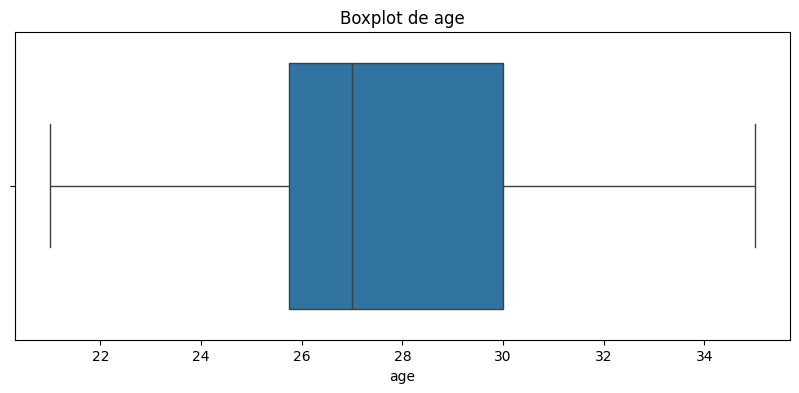

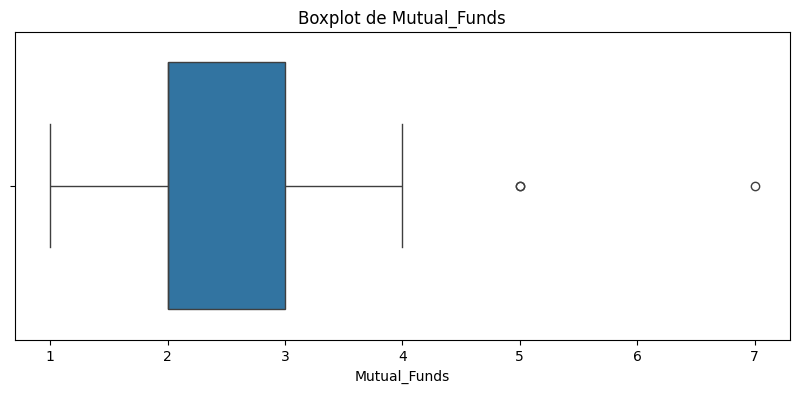

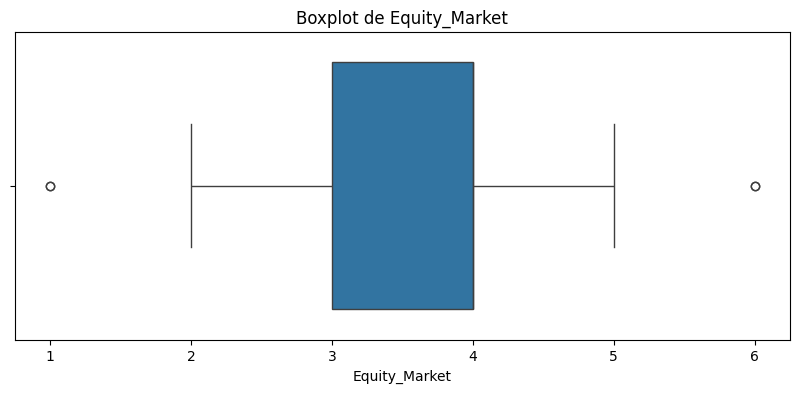


Original:
             age  Mutual_Funds  Equity_Market  Debentures  Government_Bonds  \
count  40.000000     40.000000      40.000000   40.000000         40.000000   
mean   27.800000      2.550000       3.475000    5.750000          4.650000   
std     3.560467      1.197219       1.131994    1.675617          1.369072   
min    21.000000      1.000000       1.000000    1.000000          1.000000   
25%    25.750000      2.000000       3.000000    5.000000          4.000000   
50%    27.000000      2.000000       4.000000    6.500000          5.000000   
75%    30.000000      3.000000       4.000000    7.000000          5.000000   
max    35.000000      7.000000       6.000000    7.000000          7.000000   

       Fixed_Deposits        PPF       Gold  
count       40.000000  40.000000  40.000000  
mean         3.575000   2.025000   5.975000  
std          1.795828   1.609069   1.143263  
min          1.000000   1.000000   2.000000  
25%          2.750000   1.000000   6.000000  
5

In [ ]:
df = pd.read_csv('Finance_data.csv')
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

z_scores = np.abs(stats.zscore(df[numeric_cols].dropna()))
z_limite = 3  
outliers_z = (z_scores > z_limite)

print("Qtd. de outliers (Z-score) por coluna:")
print(outliers_z.sum(axis=0))

Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers_iqr = ((df[numeric_cols] < limite_inferior) | (df[numeric_cols] > limite_superior))

print("\nQtd. de outliers (IQR) por coluna:")
print(outliers_iqr.sum())

for col in numeric_cols[:3]:
    plt.figure(figsize=(10,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot de {col}')
    plt.show()

out_any = outliers_iqr.any(axis=1)
df_sem_outliers = df[~out_any]

df_capped = df.copy()
for col in numeric_cols:
    df_capped[col] = df_capped[col].clip(limite_inferior[col], limite_superior[col])

df_log = df.copy()
for col in numeric_cols:
    if (df_log[col] >= 0).all():
        df_log[col] = np.log1p(df_log[col])

print("\nOriginal:")
print(df[numeric_cols].describe())

print("\nSem outliers (remoção):")
print(df_sem_outliers[numeric_cols].describe())

print("\nCom capping:")
print(df_capped[numeric_cols].describe())

print("\nCom log1p:")
print(df_log[numeric_cols].describe())

### Exercicio 5

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4394 entries, 0 to 4393
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   goods-title-link--jump       38 non-null     object 
 1   goods-title-link--jump href  38 non-null     object 
 2   rank-title                   747 non-null    object 
 3   rank-sub                     747 non-null    object 
 4   price                        4394 non-null   object 
 5   discount                     1525 non-null   object 
 6   selling_proposition          3167 non-null   object 
 7   color-count                  1138 non-null   float64
 8   goods-title-link             4356 non-null   object 
dtypes: float64(1), object(8)
memory usage: 309.1+ KB
None
                         goods-title-link--jump  \
count                                        38   
unique                                       38   
top     10pcs Random Color Data Cable Organi

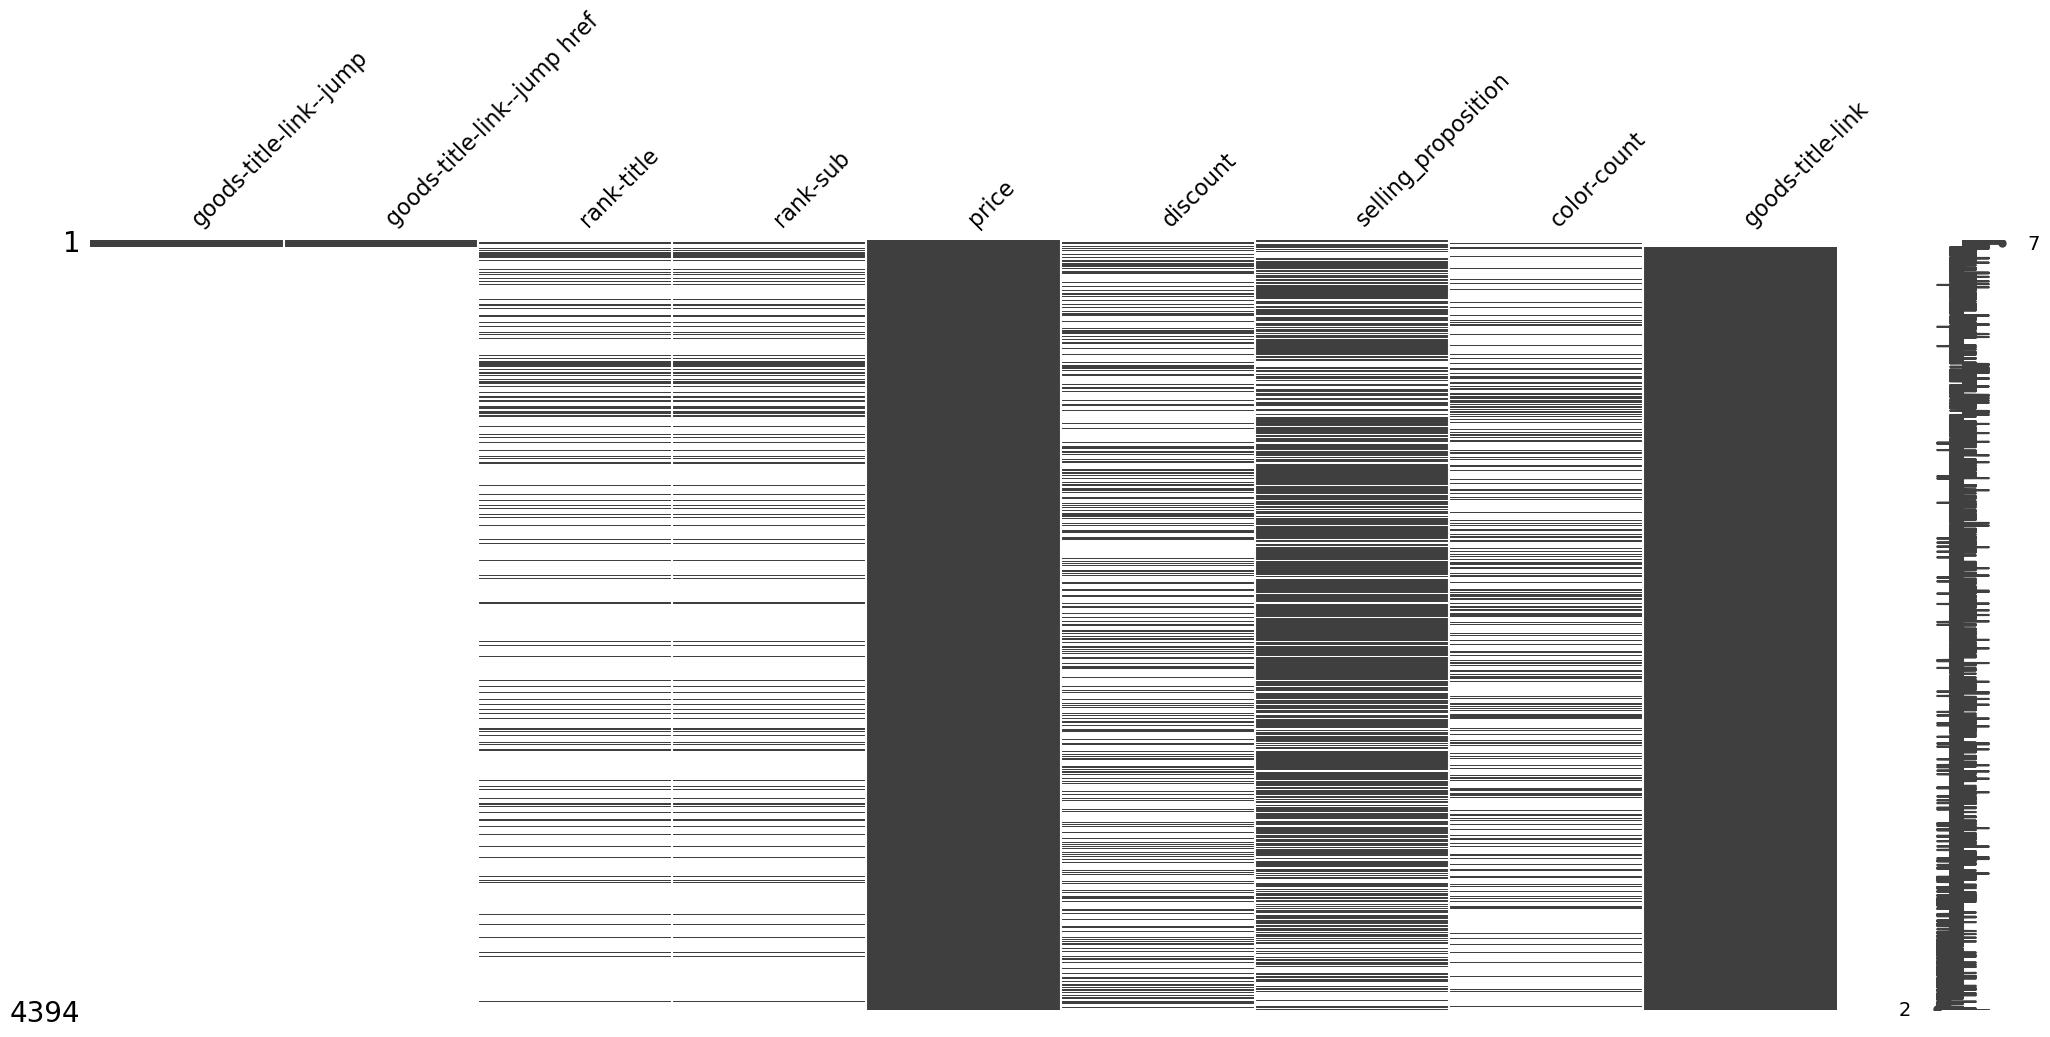

Duplicatas antes: 35

Antes da limpeza:
       color-count
count  1138.000000
mean      6.494728
std       3.578307
min       4.000000
25%       4.000000
50%       5.000000
75%       7.000000
max      31.000000

Depois da limpeza:
       color-count
count       4359.0
mean           5.0
std            0.0
min            5.0
25%            5.0
50%            5.0
75%            5.0
max            5.0

Duplicatas antes: 34
Duplicatas depois: 1


In [43]:
df_raw = pd.read_csv("us-shein-electronics-4395.csv")

df = df_raw.copy()

print(df.info())
print(df.describe(include='all'))
print("\nNA por coluna:")
print(df.isnull().sum())

msno.matrix(df)
plt.show()

num_cols = df.select_dtypes(include=['int64','float64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna('desconhecido')

print("Duplicatas antes:", df.duplicated().sum())
df = df.drop_duplicates()

for col in cat_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.strip()
        .str.lower()
    )

Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR

for col in num_cols:
    df[col] = df[col].clip(low[col], high[col])

if set(['price','discount_rate']).issubset(df.columns):
    df['discounted_price'] = df['price'] * (1 - df['discount_rate'])

print("\nAntes da limpeza:")
print(df_raw[num_cols].describe())
print("\nDepois da limpeza:")
print(df[num_cols].describe())

print("\nDuplicatas antes:", df_raw.duplicated().sum())
print("Duplicatas depois:", df.duplicated().sum())